In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import logging

from scipy.stats.mstats import winsorize
from scipy.stats import shapiro, mannwhitneyu

from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, auc, roc_curve, r2_score, mean_squared_error)
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier                  
import xgboost as xgb

In [2]:
df = pd.read_csv('acceptedcombined.00-25.csv')
sp_df = pd.read_csv('sp.csv')

In [3]:
def custom_date_parser(date_str, max_year=2025):
    """
    Parse a date string with two-digit year. If the parsed year is greater than
    max_year, assume it belongs to the previous century.
    
    Parameters:
    - date_str: The date string (e.g., "12/30/27").
    - max_year: The maximum acceptable year (e.g., 2025). If the parsed year is higher,
      subtract 100.
    
    Returns:
    - A datetime object.
    """
    # Parse using the standard format; by default, "%y" interprets values 0-68 as 2000-2068
    dt = pd.to_datetime(date_str, format="%m/%d/%y")
    # If the year is greater than max_year, assume it should be in the 1900s and subtract 100 years.
    if dt.year > max_year:
        dt = dt.replace(year=dt.year - 100)
    return dt

# Assume dj_df is your dataframe with a "Date" column containing strings like "12/30/27"
sp_df['Date'] = sp_df['Date'].apply(custom_date_parser)

# Remove rows with dates before 1999, as they're not used in your model.
sp_df = sp_df[sp_df['Date'] >= pd.Timestamp('1999-01-01')]

# Ensure both DataFrames have their date columns in datetime format
df['acceptedDate'] = pd.to_datetime(df['acceptedDate'])
sp_df['Date'] = pd.to_datetime(sp_df['Date'])
sp_df.rename(columns={'Date': 'acceptedDate'}, inplace=True)
# Sort both DataFrames by date
df = df.sort_values('acceptedDate')
sp_df = sp_df.sort_values('acceptedDate')

df = pd.merge_asof(
    df,
    sp_df,            # This DataFrame should include the Dow Jones return, price, or other metric you want
    on='acceptedDate',
    direction='backward',  # Aligns with the most recent prior Dow data
    suffixes=('', '_dj')
)

In [4]:
# Define a helper function for safe division to avoid division by zero
def safe_divide(numerator, denominator):
    return numerator / denominator.replace(0, np.nan)


# 1. Basic Calculations
df['totalCurrentLiabilities'] = df['totalCurrentLiabilities'].fillna(df['totalLiabilities'])
df['totalEquity'] = df['totalLiabilitiesAndTotalEquity'] - df['totalLiabilities']


# 2. Liquidity & Leverage Ratios
df['currentRatio'] = df['totalCurrentAssets'] / df['totalCurrentLiabilities']
df['debtToEquity'] = df['totalDebt'] / df['totalEquity']
df['liabilitiesToEquity'] = df['totalLiabilities'] / df['totalEquity']
df['debt_ratio'] = df['totalLiabilities'] / df['totalAssets']
df['netDebtRatio'] = df['netDebt'] / df['totalAssets']
df['cash_ratio'] = df['cashAndShortTermInvestments'] / df['totalCurrentLiabilities']
df['Deferred_Revenue_to_Revenue'] = df['deferredRevenue'] / df['revenue'].replace(0, np.nan)
df['Deferred_Revenue_to_Current_Liabilities'] = df['deferredRevenue'] / df['totalCurrentLiabilities'].replace(0, np.nan)


# 3. Profitability & Efficiency Metrics
df['ROE'] = df['netIncome_x'] / df['totalEquity']
df['ROA'] = df['netIncome_x'] / df['totalAssets']
df['Profit_Margin'] = df['netIncome_x'] / df['revenue']
df['inventoryTurnover'] = df['costOfRevenue'] / df['inventory_x']
df['free_cash_flow_yield'] = df['freeCashFlow'] / df['totalEquity']
df['Op_Cash_Flow_to_Revenue'] = df['operatingCashFlow'] / df['revenue']
df['Op_Cash_Flow_to_Liabilities'] = df['operatingCashFlow'] / df['totalCurrentLiabilities']
df['interest_coverage'] = df['operatingIncome'] / df['interestExpense']
df['capital_light'] = df['capitalExpenditure'] / df['operatingCashFlow']
# Daily return by stock symbol (as percentage change)
df['Return'] = df.groupby('symbol_stock')['Adj Close'].pct_change()


# 4. Investment & Valuation Metrics
df['longinvest_to_assets'] = df['longTermInvestments'] / df['totalAssets']
df['longinvest_to_equity'] = df['longTermInvestments'] / df['totalEquity']
df['Book_Value_per_share'] = df['totalStockholdersEquity'] / df['weightedAverageShsOut']
df['PE_ratio'] = df['Adj Close'] / df['eps'].replace(0, np.nan)
df['PB_ratio'] = df['Adj Close'] / df['Book_Value_per_share'].replace(0, np.nan)
df['ROI'] = safe_divide(df['netIncome_x'], df['totalInvestments'])


# 5. Earnings Related Metrics
df['retained_earnings'] = df['netIncome_x'] - df['dividendsPaid']
df['re_ratio'] = df['retained_earnings'] / df['netIncome_x']


# 6. Sector-Level & Expense Ratios
df['goodwillIntangible_to_assets'] = df['goodwillAndIntangibleAssets'] / df['totalAssets']
df['sellingMarketing_to_revenue'] = df['sellingAndMarketingExpenses'] / df['revenue']
df['totalInvestments_to_assets'] = df['totalInvestments'] / df['totalAssets']
df['rnd_to_revenue'] = df['researchAndDevelopmentExpenses'] / df['revenue']
df['inventory_to_assets'] = df['inventory_x'] / df['totalAssets']
df['taxAssetsRatio'] = df['taxAssets'] / df['totalAssets']


# 7. Growth columns
df['revenue_growth_quarterly'] = df.groupby('symbol_stock')['revenue'].pct_change(periods=1)
df['revenue_growth_annual'] = df.groupby('symbol_stock')['revenue'].pct_change(periods=4)

df['eps_growth_quarterly'] = df.groupby('symbol_stock')['epsdiluted'].pct_change(periods=1)
df['eps_growth_annual'] = df.groupby('symbol_stock')['epsdiluted'].pct_change(periods=4)


# 8. Add Lag Features and Rolling
lag_features = ['ROE', 'ROA', 'free_cash_flow_yield', 're_ratio', 'Profit_Margin',
                'debtToEquity', 'eps', 'epsdiluted', 'ebitda', 'goodwillIntangible_to_assets',
                'sellingMarketing_to_revenue', 'totalInvestments_to_assets', 'rnd_to_revenue',
                'inventory_to_assets']
for feature in lag_features:
    df[f'{feature}_lag1'] = df.groupby('symbol_stock')[feature].shift(1)
    df[f'{feature}_lag4'] = df.groupby('symbol_stock')[feature].shift(4)

rolling_features = ['ROE', 'ROA', 'free_cash_flow_yield', 're_ratio', 'Profit_Margin',
                    'debtToEquity', 'eps', 'epsdiluted', 'ebitda', 'goodwillIntangible_to_assets',
                    'sellingMarketing_to_revenue', 'totalInvestments_to_assets', 'rnd_to_revenue',
                    'inventory_to_assets']

# Using min_periods to require a minimum number of data points
for feature in rolling_features:
    df[f'{feature}_roll4'] = df.groupby('symbol_stock')[feature].transform(
        lambda x: x.rolling(window=4, min_periods=1).mean()
    )

for feature in rolling_features:
    df[f'{feature}_roll8'] = df.groupby('symbol_stock')[feature].transform(
        lambda x: x.rolling(window=8, min_periods=1).mean()
)

/var/folders/qt/m1d2k3qd4_z368vlhrz0r7w80000gn/T/ipykernel_47686/1189515490.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_roll8'] = df.groupby('symbol_stock')[feature].transform(
/var/folders/qt/m1d2k3qd4_z368vlhrz0r7w80000gn/T/ipykernel_47686/1189515490.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_roll8'] = df.groupby('symbol_stock')[feature].transform(


In [5]:
df['accepted_date'] = pd.to_datetime(df['acceptedDate'])
# Set target horizon to one quarter (90 days)
horizon_days = 90  
df['target_date'] = df['accepted_date'] + pd.Timedelta(days=horizon_days)
df = df.sort_values(by=['symbol_stock', 'accepted_date'])

df_prices = (
    df[['symbol_stock', 'accepted_date', 'Adj Close', 'Close']]
    .rename(columns={
        'accepted_date': 'future_date',
        'Adj Close': 'future_price',
        'Close': 'future_sp'
    })
    .sort_values('future_date')
)

df = df.dropna(subset=['accepted_date'])
df_prices = df_prices.dropna(subset=['future_date'])

df_model = pd.merge_asof(
    left=df.sort_values('target_date'),
    right=df_prices,
    left_on='target_date',
    right_on='future_date',
    by='symbol_stock',
    direction='forward'
)

# Calculating Future Return
df_model['Return_future'] = (df_model['future_price'] - df_model['Adj Close']) / df_model['Adj Close']
df_model = df_model.dropna(subset=['Return_future']).copy()

# Replace infinite values with NaN 
df_model.replace([np.inf, -np.inf], np.nan, inplace=True)


# Calculating Relative Return using SP500 returns
sp_return = (df_model['future_sp'] - df_model['Close']) / df_model['Close']
df_model['relative_return'] = df_model['Return_future'] - sp_return

# Flagging stocks with a relative return above the specified threshold
threshold = 0.0
df_model['good_stock'] = (df_model['relative_return'] > threshold).astype(int)

cols_to_check = ['Book_Value_per_share', 'PE_ratio', 'PB_ratio']
df_model = df_model[np.isfinite(df_model[cols_to_check]).all(axis=1)]

df_model.reset_index(drop=True, inplace=True)
print("Value counts of good_stock:")
print(df_model['good_stock'].value_counts())
print("Cleaned DataFrame shape:", df_model.shape)

/var/folders/qt/m1d2k3qd4_z368vlhrz0r7w80000gn/T/ipykernel_47686/3939707846.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['accepted_date'] = pd.to_datetime(df['acceptedDate'])
/var/folders/qt/m1d2k3qd4_z368vlhrz0r7w80000gn/T/ipykernel_47686/3939707846.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target_date'] = df['accepted_date'] + pd.Timedelta(days=horizon_days)


Value counts of good_stock:
good_stock
1    112167
0    111944
Name: count, dtype: int64
Cleaned DataFrame shape: (224111, 241)


In [6]:
final_df = df_model.copy()

features = ['ROA', 'ROE', 'epsdiluted', 'ROI', 'Profit_Margin']

X = final_df[features]
y = final_df['good_stock']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Concatenate features and target for training set, drop rows with NANs
train = pd.concat([X_train, y_train], axis=1).dropna()
X_train = train[features]
y_train = train['good_stock']

# Same for the test set
test = pd.concat([X_test, y_test], axis=1).dropna()
X_test = test[features]
y_test = test['good_stock']


# Initialize and train the log regression model
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = baseline_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5023463023463024

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.27      0.36     16989
           1       0.50      0.74      0.59     16681

    accuracy                           0.50     33670
   macro avg       0.51      0.50      0.48     33670
weighted avg       0.51      0.50      0.47     33670



Trades Summary (first few rows):
  symbol_stock          entry_date           exit_date  trade_return Quarter
0          AAL 2007-10-18 16:47:45 2007-12-30 19:00:00     -0.475336  2007Q4
1          AAL 2008-10-16 17:30:13 2012-02-15 16:50:27      0.305209  2012Q1
2          AAL 2013-02-20 16:01:06 2013-04-18 16:11:18      0.201801  2013Q2
3          AAL 2017-10-26 08:01:31 2022-04-21 07:04:39     -0.578290  2022Q2
4         AAOI 2014-11-12 16:46:25 2017-11-08 16:10:41      2.536208  2017Q4

Enhanced Trade-Level Backtest Performance (Baseline Model):
Quarterly Trade Returns:
 2000Q1   -0.010000
2000Q2    0.233333
2000Q3   -0.323932
2000Q4   -0.118354
2001Q1    0.052661
            ...   
2023Q3    1.902819
2023Q4    2.407552
2024Q1    1.947570
2024Q2    2.189994
2024Q3    2.362943
Freq: Q-DEC, Name: trade_return, Length: 99, dtype: float64
Cumulative Portfolio Returns:
 2000Q1    9.900000e-01
2000Q2    1.221000e+00
2000Q3    8.254789e-01
2000Q4    7.277803e-01
2001Q1    7.661062e-01
   

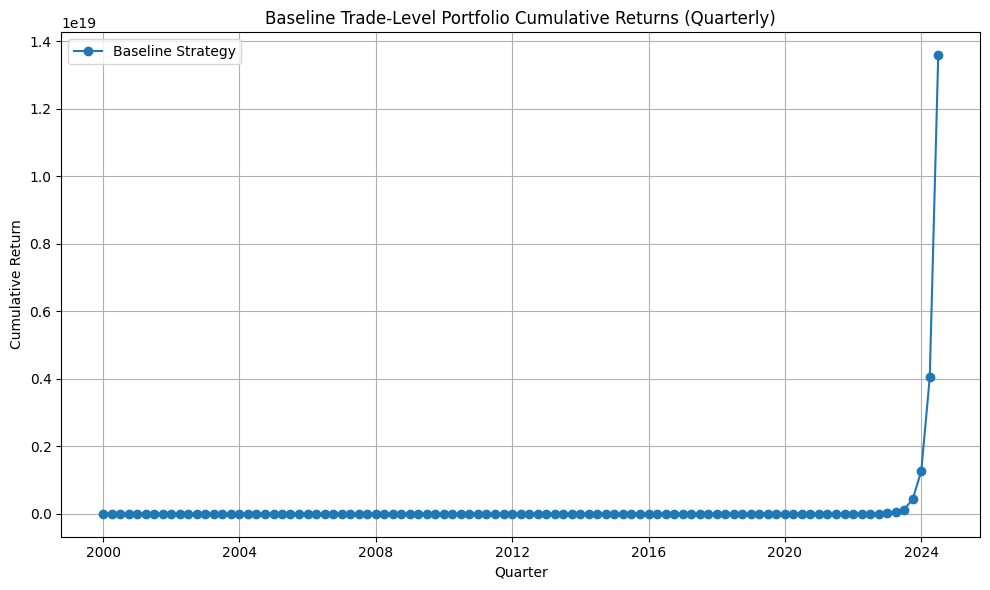

In [ ]:
# Define test_df using the index of X_test from your baseline model.
test_df = final_df.loc[X_test.index].copy()

# Parameters for realistic trade simulation
transaction_cost = 0.001  # 0.1% per trade which is applied at entry and exit
slippage = 0.002          # 0.2% additional cost per trade side

# ENSURE! test_sim is sorted appropriately
test_sim = test_df.copy().sort_values(['symbol_stock', 'accepted_date'])

# Generate predicted signals using the baseline model on the correct DataFrame
test_sim['predicted_signal'] = baseline_model.predict(test_sim[features])

def simulate_trades_for_stock(stock_df, transaction_cost, slippage):
    """
    Simulate trades for one stock using the predicted signal.
    - When the signal is 1 and no position is open, "buy" at the current quarter's Adj Close.
    - When a position is open and the signal turns 0, "sell" at the current quarter's Adj Close.
    - If a position remains open until the end, close it at the last available price.
    
    Returns a list of dictionaries with 'symbol_stock', 'entry_date', 'exit_date', and 'trade_return'.
    """
    trades = []
    open_trade = None  # Will hold a dict with entry_date and entry_price when a trade is open
    
    # Iterate over rows chronologically
    for i, row in stock_df.iterrows():
        date = row['accepted_date']
        price = row['Adj Close']
        signal = row['predicted_signal']
        
        if open_trade is None:
            # No open position: if signal==1, then buy
            if signal == 1:
                open_trade = {
                    'entry_date': date,
                    'entry_price': price
                }
        else:
            # Position is open
            if signal == 0:
                # Sell signal: close trade at current price
                exit_price = price
                raw_return = exit_price / open_trade['entry_price'] - 1
                # Apply transaction costs and slippage on both entry and exit
                net_return = raw_return - 2 * (transaction_cost + slippage)
                trades.append({
                    'symbol_stock': row['symbol_stock'],
                    'entry_date': open_trade['entry_date'],
                    'exit_date': date,
                    'trade_return': net_return
                })
                open_trade = None  # Reset the open trade
            
    # If a trade is still open at the end, close it at the last available price
    if open_trade is not None:
        last_row = stock_df.iloc[-1]
        exit_price = last_row['Adj Close']
        raw_return = exit_price / open_trade['entry_price'] - 1
        net_return = raw_return - 2 * (transaction_cost + slippage)
        trades.append({
            'symbol_stock': last_row['symbol_stock'],
            'entry_date': open_trade['entry_date'],
            'exit_date': last_row['accepted_date'],
            'trade_return': net_return
        })
    return trades


# Simulate trades
all_trades = []
for symbol, group in test_sim.groupby('symbol_stock'):
    trades = simulate_trades_for_stock(group, transaction_cost, slippage)
    all_trades.extend(trades)

trades_df = pd.DataFrame(all_trades)
# Ensure date columns are in datetime format
trades_df['entry_date'] = pd.to_datetime(trades_df['entry_date'])
trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'])

# Create a Quarter column based on the exit date (when the trade closed)
trades_df['Quarter'] = trades_df['exit_date'].dt.to_period('Q')

print("Trades Summary (first few rows):")
print(trades_df.head())


# Agg trade returns by quarter
quarterly_trade_returns = trades_df.groupby('Quarter')['trade_return'].mean()

# Reindex the series to include all quarters in the test period
all_quarters = pd.period_range(start=test_sim['accepted_date'].min().to_period('Q'),
                               end=test_sim['accepted_date'].max().to_period('Q'),
                               freq='Q')

# If a quarter had no trades, assume an opportunity cost (-1%)
quarterly_trade_returns = quarterly_trade_returns.reindex(all_quarters, fill_value=-0.01)


# Compute cumulative returns and other performance metrics
cumulative_returns = (1 + quarterly_trade_returns).cumprod()

annualized_return = (1 + cumulative_returns.iloc[-1]) ** (4 / len(cumulative_returns)) - 1  # 4 quarters per year
sharpe_ratio = quarterly_trade_returns.mean() / quarterly_trade_returns.std() * np.sqrt(4)
peak = cumulative_returns.cummax()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = drawdown.min()

print("\nEnhanced Trade-Level Backtest Performance (Baseline Model):")
print("Quarterly Trade Returns:\n", quarterly_trade_returns)
print("Cumulative Portfolio Returns:\n", cumulative_returns)
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns.index.to_timestamp(), cumulative_returns, marker='o', label='Baseline Strategy')
plt.title("Baseline Trade-Level Portfolio Cumulative Returns (Quarterly)")
plt.xlabel("Quarter")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()